Regression using LightGBM

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/content/medical_cost.csv')

In [3]:
df.head()

,Id,age,sex,bmi,children,smoker,region,charges
0,1,19,female,27.900,0,yes,southwest,16884.92400
1,2,18,male,33.770,1,no,southeast,1725.55230
2,3,28,male,33.000,3,no,southeast,4449.46200
3,4,33,male,22.705,0,no,northwest,21984.47061
4,5,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.describe()

,Id,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,669.500000,39.207025,30.663397,1.094918,13270.422265
std,386.391641,14.049960,6.098187,1.205493,12110.011237
min,1.000000,18.000000,15.960000,0.000000,1121.873900
25%,335.250000,27.000000,26.296250,0.000000,4740.287150
50%,669.500000,39.000000,30.400000,1.000000,9382.033000
75%,1003.750000,51.000000,34.693750,2.000000,16639.912515
max,1338.000000,64.000000,53.130000,5.000000,63770.428010


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Id        1338 non-null   int64  
 1   age       1338 non-null   int64  
 2   sex       1338 non-null   object 
 3   bmi       1338 non-null   float64
 4   children  1338 non-null   int64  
 5   smoker    1338 non-null   object 
 6   region    1338 non-null   object 
 7   charges   1338 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 83.8+ KB


In [8]:
categorical_cols = ['sex', 'children', 'smoker', 'region']

for col in categorical_cols:
    grouped_data = df[[col, 'charges']].groupby(col).mean()
    print(f"Mean charges by {col}:")
    print(grouped_data)
    print()

Mean charges by sex:
             charges
sex                 
female  12569.578844
male    13956.751178

Mean charges by children:
               charges
children              
0         12365.975602
1         12731.171832
2         15073.563734
3         15355.318367
4         13850.656311
5          8786.035247

Mean charges by smoker:
             charges
smoker              
no       8434.268298
yes     32050.231832

Mean charges by region:
                charges
region                 
northeast  13406.384516
northwest  12417.575374
southeast  14735.411438
southwest  12346.937377



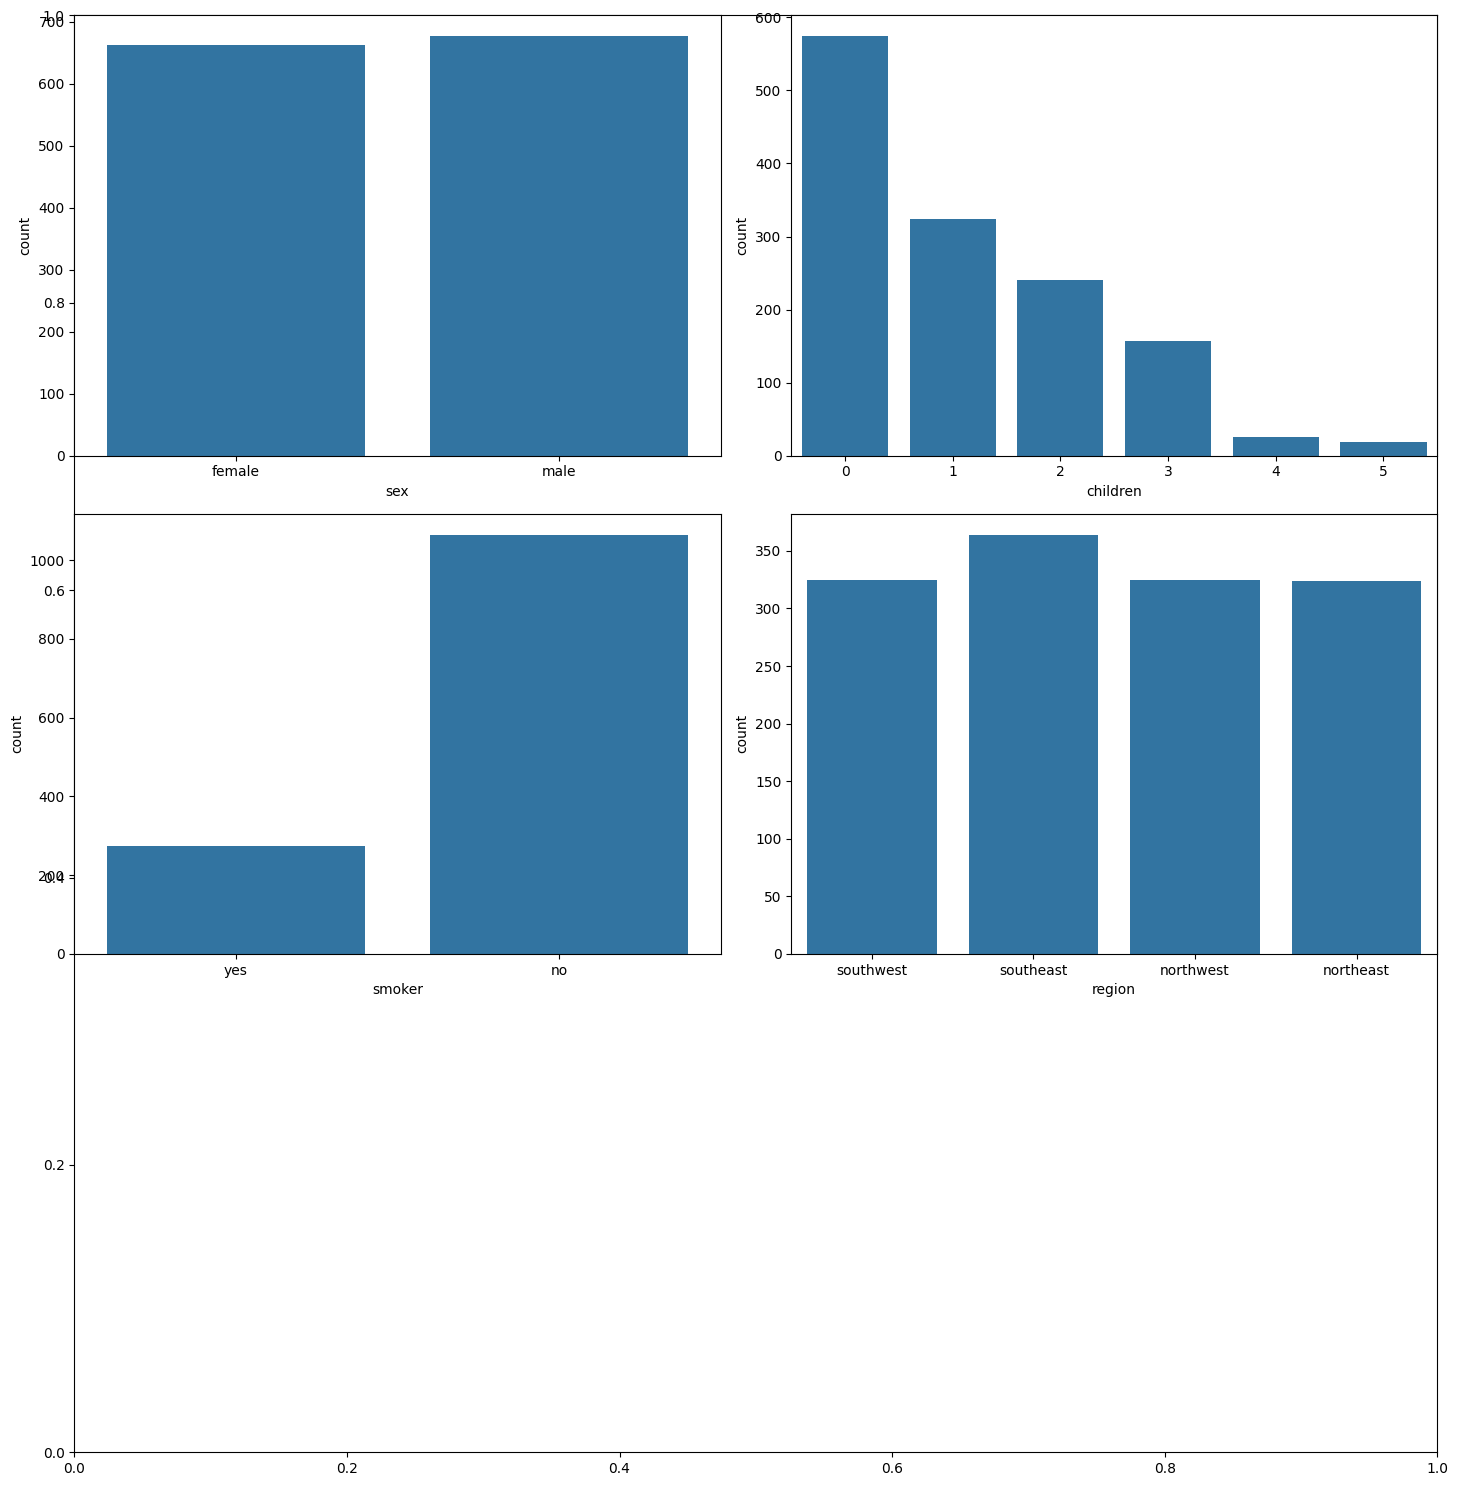

In [9]:
plt.subplots(figsize=(15, 15))
for i, col in enumerate(categorical_cols):
    plt.subplot(3, 2, i + 1)
    sb.countplot(data=df, x=col)
plt.tight_layout()
plt.show()

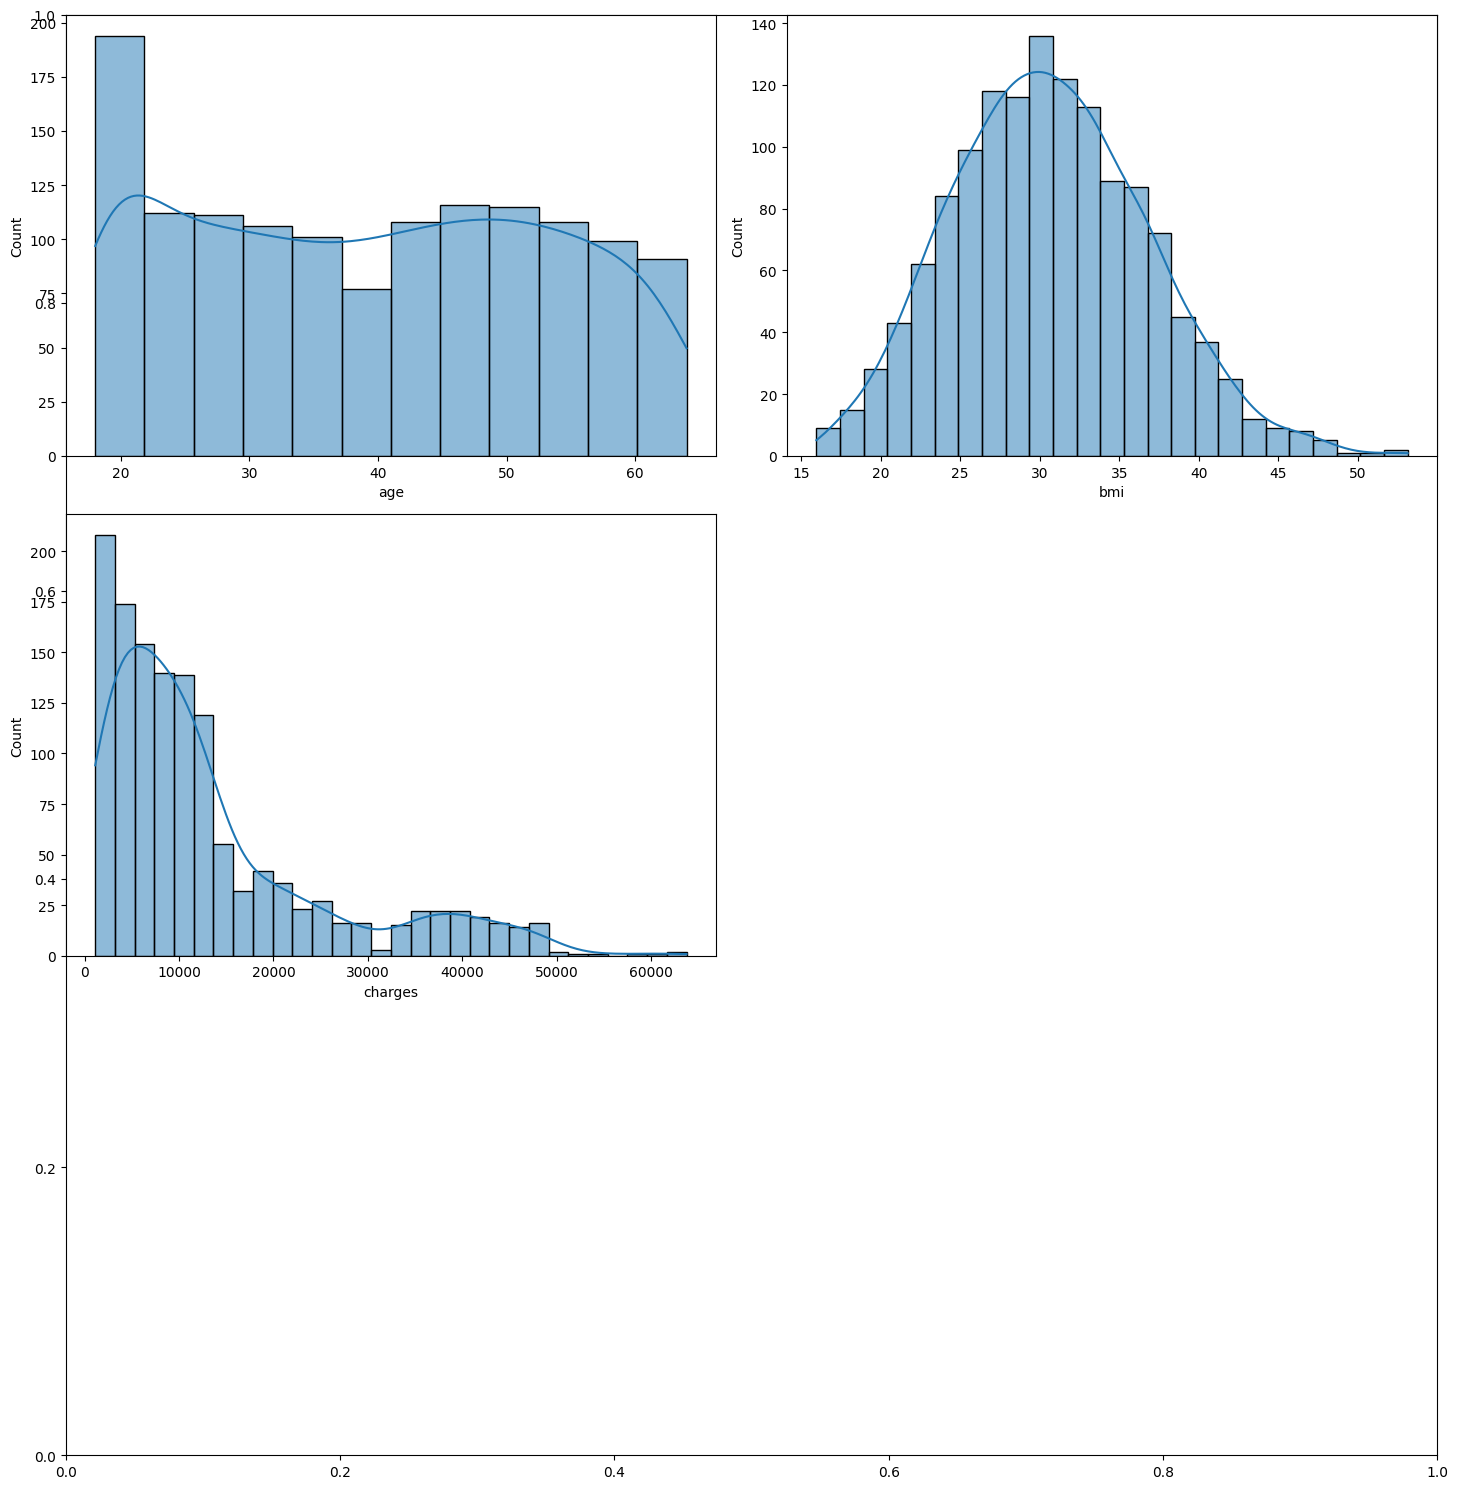

In [10]:
numeric_cols = ['age', 'bmi', 'charges']

plt.subplots(figsize=(15, 15))
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 2, i + 1)
    sb.histplot(df[col], kde=True)
plt.tight_layout()
plt.show()

In [11]:
df['sex'] = df['sex'].map({'male': 0, 'female': 1})
df['smoker'] = df['smoker'].map({'no': 0, 'yes': 1})
df.head()

,Id,age,sex,bmi,children,smoker,region,charges
0,1,19,1,27.900,0,1,southwest,16884.92400
1,2,18,0,33.770,1,0,southeast,1725.55230
2,3,28,0,33.000,3,0,southeast,4449.46200
3,4,33,0,22.705,0,0,northwest,21984.47061
4,5,32,0,28.880,0,0,northwest,3866.85520


In [12]:
df = pd.concat([df, pd.get_dummies(df['region']).astype('int')], axis=1)
df.drop(['Id', 'region'], inplace=True, axis=1)
df.head()

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest
0,19,1,27.900,0,1,16884.92400,0,0,0,1
1,18,0,33.770,1,0,1725.55230,0,0,1,0
2,28,0,33.000,3,0,4449.46200,0,0,1,0
3,33,0,22.705,0,0,21984.47061,0,1,0,0
4,32,0,28.880,0,0,3866.85520,0,1,0,0


In [13]:
features = df.drop('charges', axis=1)
target = df['charges']

X_train, X_val, Y_train, Y_val = train_test_split(
    features, target, test_size=0.25, random_state=2023
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [14]:
train_data = lgb.Dataset(X_train, label=Y_train)
test_data = lgb.Dataset(X_val, label=Y_val, reference=train_data)

In [16]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[
                test_data])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 1003, number of used features: 9
[LightGBM] [Info] Start training from score 13075.303458


In [17]:
model = LGBMRegressor(metric='rmse')
model.fit(X_train, Y_train)

y_train = model.predict(X_train)
y_val = model.predict(X_val)

print("Training RMSE: ", np.sqrt(mse(Y_train, y_train)))
print("Validation RMSE: ", np.sqrt(mse(Y_val, y_val)))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 1003, number of used features: 9
[LightGBM] [Info] Start training from score 13075.303458
Training RMSE:  2815.1275630652895
Validation RMSE:  4798.297973447336


Binary classification using LightGBM

In [19]:
pip install lightgbm

In [20]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/content/diabetes.csv')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


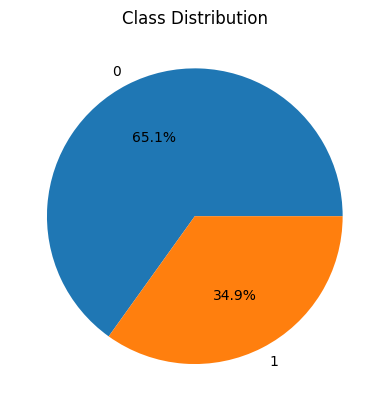

In [22]:
temp = df['Outcome'].value_counts()
plt.pie(temp.values, labels=temp.index.values, autopct='%1.1f%%')
plt.title("Class Distribution")
plt.show()

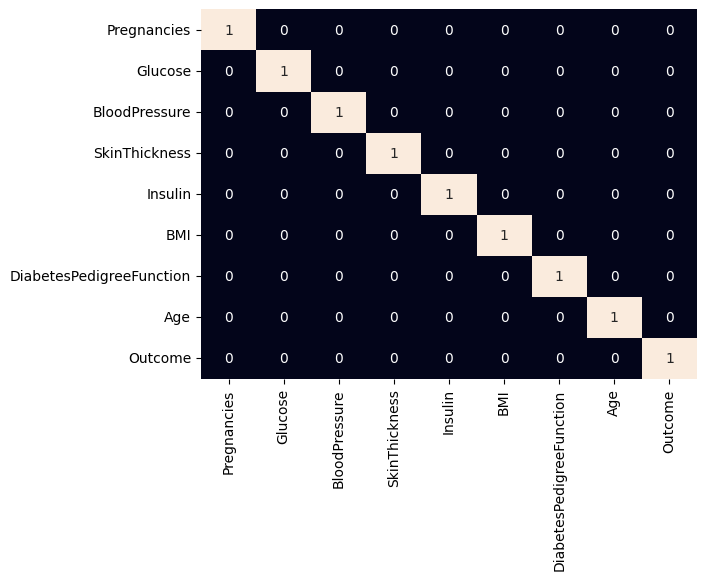

In [23]:
sb.heatmap(df.corr() > 0.7, cbar=False, annot=True)
plt.show()

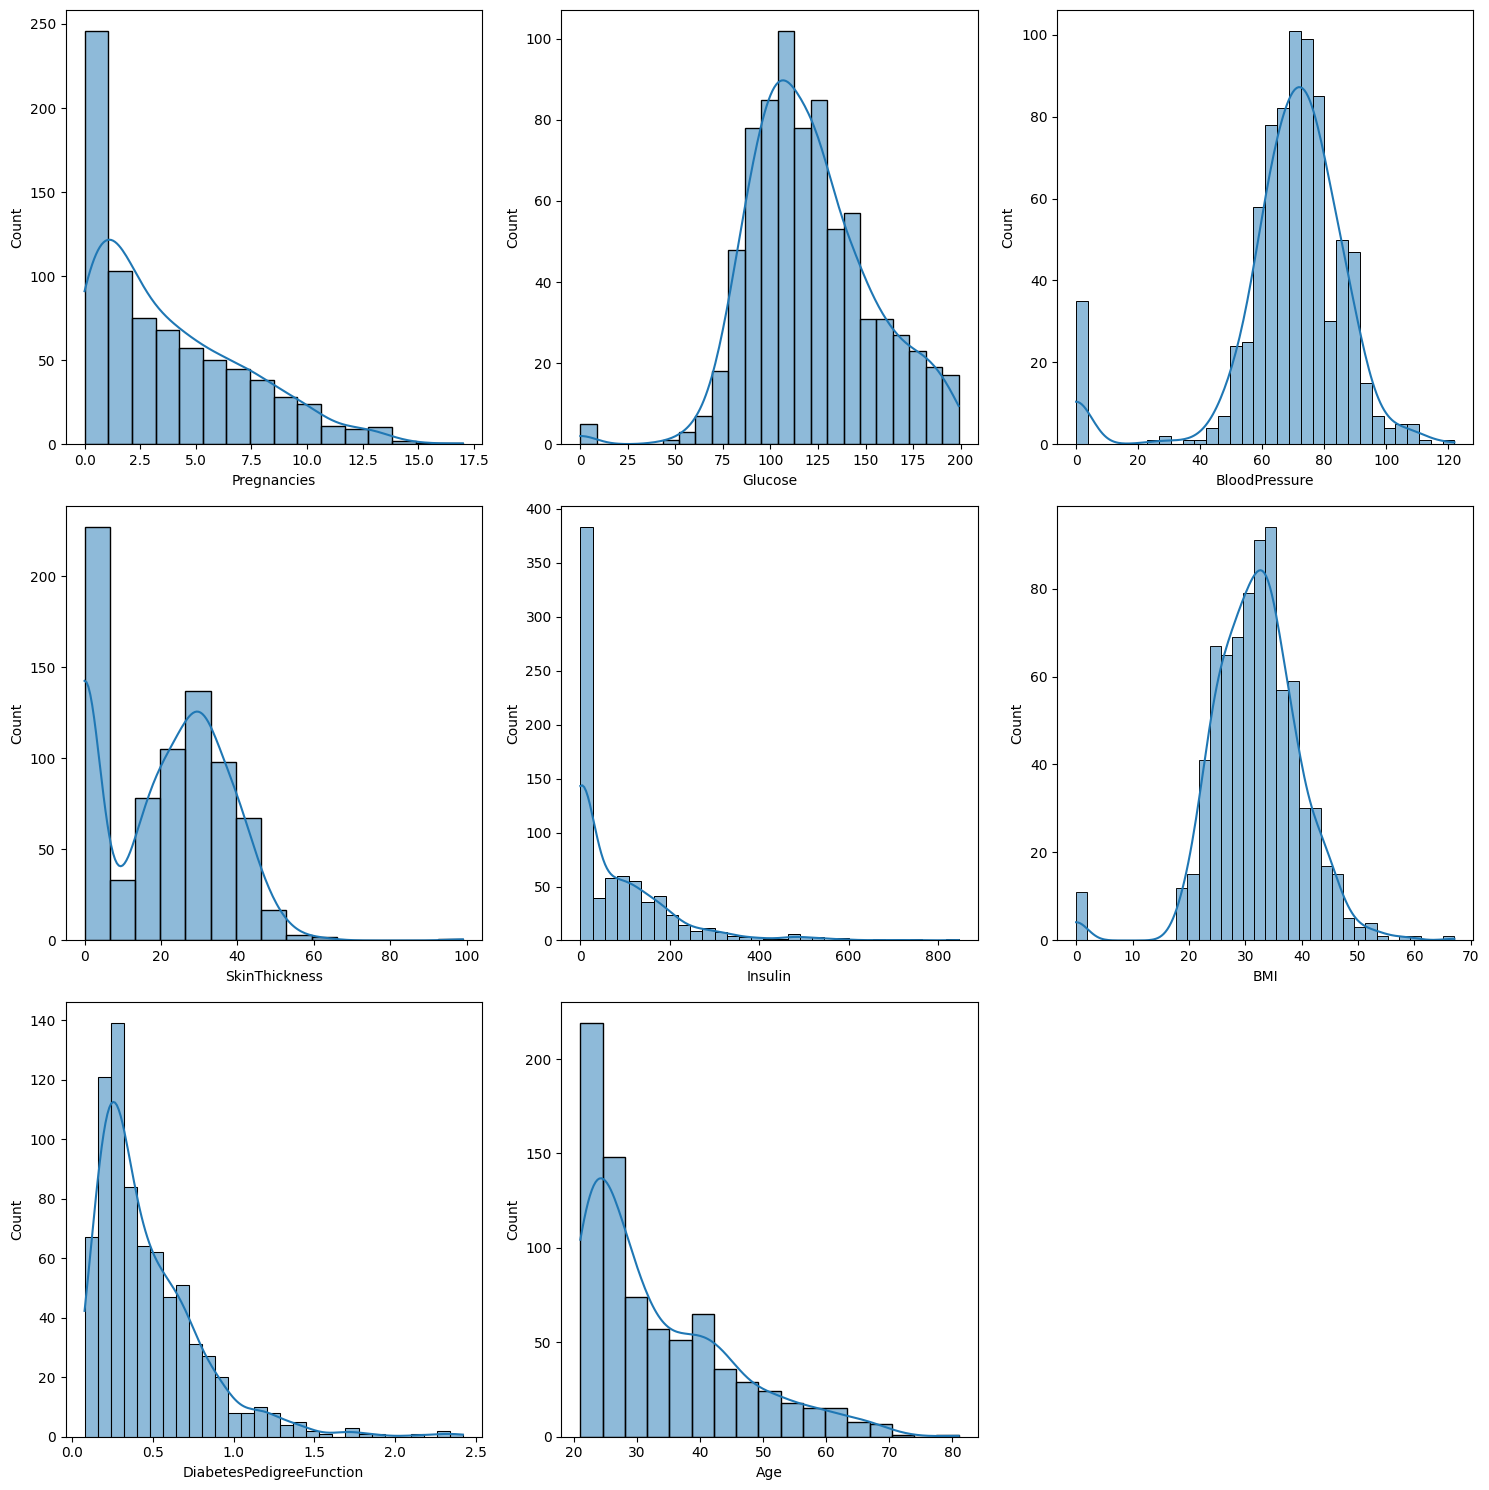

In [24]:
num_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
            'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

plt.figure(figsize=(15, 15))
for col in num_cols:
    plt.subplot(3, 3, num_cols.index(col)+1)
    sb.histplot(df[col], kde=True)

plt.tight_layout()
plt.show()

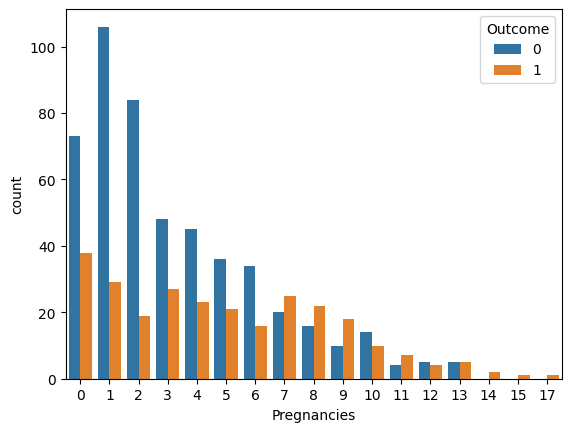

In [25]:
sb.countplot(data=df, x='Pregnancies', hue='Outcome')
plt.show()

In [26]:
features = df.drop('Outcome', axis=1)
target = df['Outcome']

X_train, X_val, Y_train, Y_val = train_test_split(
    features, target, test_size=0.2, random_state=2023
)

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [28]:
train_data = lgb.Dataset(X_train, label=Y_train)
test_data = lgb.Dataset(X_val, label=Y_val, reference=train_data)

In [30]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

[LightGBM] [Info] Number of positive: 211, number of negative: 403
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.343648 -> initscore=-0.647078
[LightGBM] [Info] Start training from score -0.647078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [32]:
from sklearn.metrics import roc_auc_score

y_train = bst.predict(X_train)
y_val = bst.predict(X_val)

y_train_class = (y_train > 0.5).astype(int)
y_val_class = (y_val > 0.5).astype(int)

print("Training ROC-AUC: ", roc_auc_score(Y_train, y_train))
print("Validation ROC-AUC: ", roc_auc_score(Y_val, y_val))

Training ROC-AUC:  0.9962014747215787
Validation ROC-AUC:  0.794176162054621


Cat boosting

In [33]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


In [34]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [36]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    verbose=0
)

model.fit(X_train, y_train)

In [38]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00
